In [1]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

import torch

print("GPU 사용 가능:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU 이름:", torch.cuda.get_device_name(0))
    print("사용 중인 디바이스:", torch.cuda.current_device())
    print("총 GPU 수:", torch.cuda.device_count())

2.6.0
1.21.4
4.11.3
1.14.0
GPU 사용 가능: True
GPU 이름: Tesla T4
사용 중인 디바이스: 0
총 GPU 수: 1


nsmc 데이터 불러오기

In [2]:
from datasets import load_dataset

ds = load_dataset("e9t/nsmc")

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
print(ds)
print(ds['train'][0])

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})
{'label': 0, 'id': '9976970', 'document': '아 더빙.. 진짜 짜증나네요 목소리'}


클래스 불균형이 있는지 검사

In [4]:
from collections import Counter

train_labels = [x['label'] for x in ds['train']]
test_labels = [x['label'] for x in ds['test']]
print("Train:", Counter(train_labels))
print("Test :", Counter(test_labels))

Train: Counter({0: 75173, 1: 74827})
Test : Counter({1: 25173, 0: 24827})


데이터 별 길이 검사

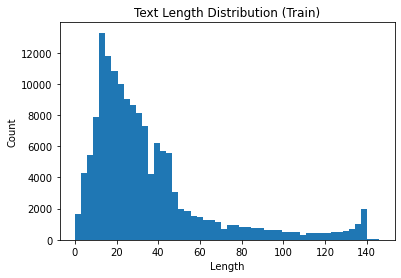

In [5]:
import matplotlib.pyplot as plt

lengths = [len(x['document']) for x in ds['train']]
plt.hist(lengths, bins=50)
plt.title("Text Length Distribution (Train)")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

In [6]:
for i in range(5):
    print(ds['train'][i]['document'])

아 더빙.. 진짜 짜증나네요 목소리
흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
너무재밓었다그래서보는것을추천한다
교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다


klue/bert-base model 및 tokenizer 불러오기

In [9]:
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

기본적인 transform에 padding의 길이가 512로 고정되어 있었기 때문에,

padding = True 값을 주어 각 batch마다 다이나믹하게 padding이 이루어지도록 했습니다.

In [10]:
def transform(data):
    return tokenizer(
        data['document'],
        truncation = True,
        padding = True,
        return_token_type_ids = False,
        )

In [11]:
hf_dataset = ds.map(transform, batched=True)
hf_dataset

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-e7728ca4533191fb.arrow


  0%|          | 0/50 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 50000
    })
})

In [12]:
from datasets import DatasetDict

# 기존 DatasetDict: ds
# 예: ds['train'], ds['test'] 존재

# 1. train 데이터를 90:10 비율로 나누기
split_ds = hf_dataset['train'].train_test_split(test_size=0.1, seed=42)

# 2. 원래 DatasetDict에 병합
hf_dataset = DatasetDict({
    'train': split_ds['train'],
    'validation': split_ds['test'],  # 10% eval set
    'test': hf_dataset['test']
})

Loading cached split indices for dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-414e4055675a23d4.arrow and /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-da6fd33af4267e13.arrow


In [13]:
from collections import Counter

train_labels = [x['label'] for x in hf_dataset['train']]
val_labels = [x['label'] for x in hf_dataset['validation']]
test_labels = [x['label'] for x in hf_dataset['test']]
print("Train:", Counter(train_labels))
print("Val :", Counter(val_labels))
print("Test :", Counter(test_labels))

Train: Counter({0: 67703, 1: 67297})
Val : Counter({1: 7530, 0: 7470})
Test : Counter({1: 25173, 0: 24827})


padding을 적용한 결과, 거의 대부분의 데이터가 90~120 정도의 길이의 패딩으로 처리되었습니다.

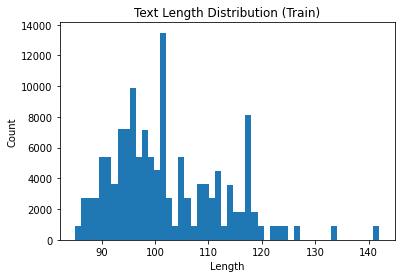

In [14]:
import matplotlib.pyplot as plt

lengths = [len(x['attention_mask']) for x in hf_dataset['train']]
plt.hist(lengths, bins=50)
plt.title("Text Length Distribution (Train)")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

학습 속도를 빠르게 하기 위해 batch_size를 최대한으로 키우고,

GPU에서 mixed precision을 사용하도록 하여 (fp16=True) 속도 향상을 유도했습니다.

mixed precision : 일부 연산은 16비트 부동소수점으로 수행. 정밀도가 낮은 대신 속도가 두 배 빠름.

In [15]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 96,   # 각 device 당 batch size
    per_device_eval_batch_size = 96,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    fp16=True,  
)

acc, precision, recall, f1을 학습 중에 모두 구하도록 했습니다.

In [18]:
from datasets import load_metric
acc_metric = load_metric("accuracy")
p_metric = load_metric("precision")
r_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        "accuracy": acc_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": p_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": r_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"],    }

In [19]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_dataset['train'],    # training dataset
    eval_dataset=hf_dataset['validation'],       # evaluation dataset
    compute_metrics=compute_metrics,
    
    data_collator=data_collator,
)
trainer.train()

Using amp fp16 backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 135000
  Num Epochs = 3
  Instantaneous batch size per device = 96
  Total train batch size (w. parallel, distributed & accumulation) = 96
  Gradient Accumulation steps = 1
  Total optimization steps = 4221


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.144300,0.265637,0.898733,0.899335,0.898733,0.898686
2,0.155000,0.262291,0.904333,0.904608,0.904333,0.904311
3,0.110600,0.292942,0.906000,0.906101,0.906000,0.905991


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 96
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint

TrainOutput(global_step=4221, training_loss=0.14114827506493066, metrics={'train_runtime': 4920.6463, 'train_samples_per_second': 82.306, 'train_steps_per_second': 0.858, 'total_flos': 2.813094603927936e+16, 'train_loss': 0.14114827506493066, 'epoch': 3.0})

In [20]:
trainer.evaluate(hf_dataset['test'])

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 96


{'eval_loss': 0.2999923527240753,
 'eval_accuracy': 0.89882,
 'eval_precision': 0.8988247540561971,
 'eval_recall': 0.89882,
 'eval_f1': 0.8988179468053329,
 'eval_runtime': 407.426,
 'eval_samples_per_second': 122.722,
 'eval_steps_per_second': 1.279,
 'epoch': 3.0}

### preprocessing 개선

In [29]:
import re

def clean(example):
    txt = example["document"]
    txt = re.sub(r"[^가-힣a-zA-Z0-9\s.,!?']", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip()
    txt = re.sub(r"(.)\1{2,}", r"\1\1", txt)
    return {"document": txt}

In [30]:
from datasets import Dataset

# 정제 적용
clean_ds = DatasetDict({
    'train': ds['train'],
    'test': ds['test'],
    'clean_train': ds['train'].map(clean),
    'clean_test': ds['test'].map(clean)
})


clean_ds

  0%|          | 0/150000 [00:00<?, ?ex/s]

  0%|          | 0/50000 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
    clean_train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    clean_test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [31]:
split_ds = clean_ds['clean_train'].train_test_split(test_size=0.1, seed=42)

# 2. 원래 DatasetDict에 병합
clean_ds = DatasetDict({
    'train': split_ds['train'],
    'validation': split_ds['test'],  # 10% eval set
    'test': clean_ds['clean_test']
})

clean_ds

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 135000
    })
    validation: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 15000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [32]:
clean_ds = clean_ds.map(transform, batched=True)
clean_ds

  0%|          | 0/135 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 135000
    })
    validation: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 15000
    })
    test: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 50000
    })
})

In [33]:
output_dir = os.getenv('HOME')+'/aiffel/transformers/trainingarg'

new_training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 96,   # 각 device 당 batch size
    per_device_eval_batch_size = 96,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    fp16=True,  
    warmup_ratio=0.1, 
    lr_scheduler_type="linear",
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [35]:
from transformers import DataCollatorWithPadding

model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,           # 학습시킬 model
    args=new_training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=clean_ds['train'],    # training dataset
    eval_dataset=clean_ds['validation'],       # evaluation dataset
    compute_metrics=compute_metrics,
    
    data_collator=data_collator,
)
trainer.train()

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file https://huggingface.co/klue/bert-base/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transform

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.283400,0.258135,0.891667,0.892648,0.891667,0.891586
2,0.208000,0.242096,0.902067,0.902853,0.902067,0.902009
3,0.158800,0.257848,0.902333,0.902515,0.902333,0.902318


Saving model checkpoint to /aiffel/aiffel/transformers/trainingarg/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/trainingarg/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/trainingarg/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/trainingarg/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/trainingarg/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/trainingarg/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 96
Saving model checkpoint to /aiffel/aiffel/transformers/trainingarg/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/trainingarg/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/tra

TrainOutput(global_step=4221, training_loss=0.23167884499505356, metrics={'train_runtime': 4630.8777, 'train_samples_per_second': 87.456, 'train_steps_per_second': 0.911, 'total_flos': 2.599925315763456e+16, 'train_loss': 0.23167884499505356, 'epoch': 3.0})

In [36]:
trainer.evaluate(clean_ds['test'])

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 96


{'eval_loss': 0.2664232552051544,
 'eval_accuracy': 0.89938,
 'eval_precision': 0.8997255774459729,
 'eval_recall': 0.89938,
 'eval_f1': 0.899346377725127,
 'eval_runtime': 397.0963,
 'eval_samples_per_second': 125.914,
 'eval_steps_per_second': 1.312,
 'epoch': 3.0}

### Bucketing 적용

In [37]:
output_dir = os.getenv('HOME')+'/aiffel/transformers/bucketing'

new_training_arguments2 = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 96,   # 각 device 당 batch size
    per_device_eval_batch_size = 96,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    fp16=True,
    group_by_length=True, # bucketing
    warmup_ratio=0.1, 
    lr_scheduler_type="linear",
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [38]:
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,           # 학습시킬 model
    args=new_training_arguments2,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=clean_ds['train'],    # training dataset
    eval_dataset=clean_ds['validation'],       # evaluation dataset
    compute_metrics=compute_metrics,
    
    data_collator=data_collator,
)
trainer.train()

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file https://huggingface.co/klue/bert-base/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transform

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.283100,0.243362,0.902400,0.902868,0.902400,0.902379
2,0.206300,0.232954,0.907200,0.907257,0.907200,0.907194
3,0.157800,0.250652,0.906467,0.906479,0.906467,0.906465


Saving model checkpoint to /aiffel/aiffel/transformers/bucketing/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/bucketing/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/bucketing/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/bucketing/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/bucketing/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/bucketing/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 96
Saving model checkpoint to /aiffel/aiffel/transformers/bucketing/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/bucketing/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/bucketing/checkpoin

TrainOutput(global_step=4221, training_loss=0.23095279721619535, metrics={'train_runtime': 3557.0876, 'train_samples_per_second': 113.857, 'train_steps_per_second': 1.187, 'total_flos': 2.067631095218976e+16, 'train_loss': 0.23095279721619535, 'epoch': 3.0})

test 데이터에 대한 성능이 소폭 상승하고, 학습도 15분 가량 빨리 끝났습니다.

In [39]:
trainer.evaluate(clean_ds['test'])

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 96


{'eval_loss': 0.25465598702430725,
 'eval_accuracy': 0.90344,
 'eval_precision': 0.9035097500330509,
 'eval_recall': 0.90344,
 'eval_f1': 0.9034305893701361,
 'eval_runtime': 398.3475,
 'eval_samples_per_second': 125.519,
 'eval_steps_per_second': 1.308,
 'epoch': 3.0}

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Trainer의 학습 로그 히스토리
log_history = trainer.state.log_history

# pandas DataFrame으로 변환
df = pd.DataFrame(log_history)

Index(['loss', 'learning_rate', 'epoch', 'step', 'eval_loss', 'eval_accuracy',
       'eval_precision', 'eval_recall', 'eval_f1', 'eval_runtime',
       'eval_samples_per_second', 'eval_steps_per_second', 'train_runtime',
       'train_samples_per_second', 'train_steps_per_second', 'total_flos',
       'train_loss'],
      dtype='object')


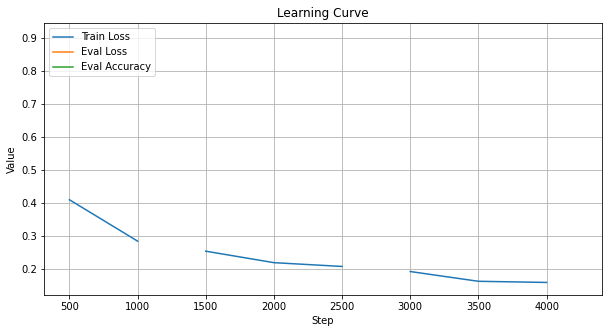

In [41]:
print(df.columns)

# loss 그래프 그리기
plt.figure(figsize=(10, 5))
if "loss" in df.columns:
    plt.plot(df["step"], df["loss"], label="Train Loss")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss")
if "eval_accuracy" in df.columns:
    plt.plot(df["step"], df["eval_accuracy"], label="Eval Accuracy")

plt.xlabel("Step")
plt.ylabel("Value")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# Trainer 로그 가져오기
df = pd.DataFrame(trainer.state.log_history)

print(df)

      loss  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0   0.4086       0.000020   0.36   500        NaN            NaN   
1   0.2831       0.000017   0.71  1000        NaN            NaN   
2      NaN            NaN   1.00  1407   0.243362       0.902400   
3   0.2526       0.000014   1.07  1500        NaN            NaN   
4   0.2178       0.000012   1.42  2000        NaN            NaN   
5   0.2063       0.000009   1.78  2500        NaN            NaN   
6      NaN            NaN   2.00  2814   0.232954       0.907200   
7   0.1909       0.000006   2.13  3000        NaN            NaN   
8   0.1613       0.000004   2.49  3500        NaN            NaN   
9   0.1578       0.000001   2.84  4000        NaN            NaN   
10     NaN            NaN   3.00  4221   0.250652       0.906467   
11     NaN            NaN   3.00  4221        NaN            NaN   
12     NaN            NaN   3.00  4221   0.254656       0.903440   

    eval_precision  eval_recall   eval_f1  eval

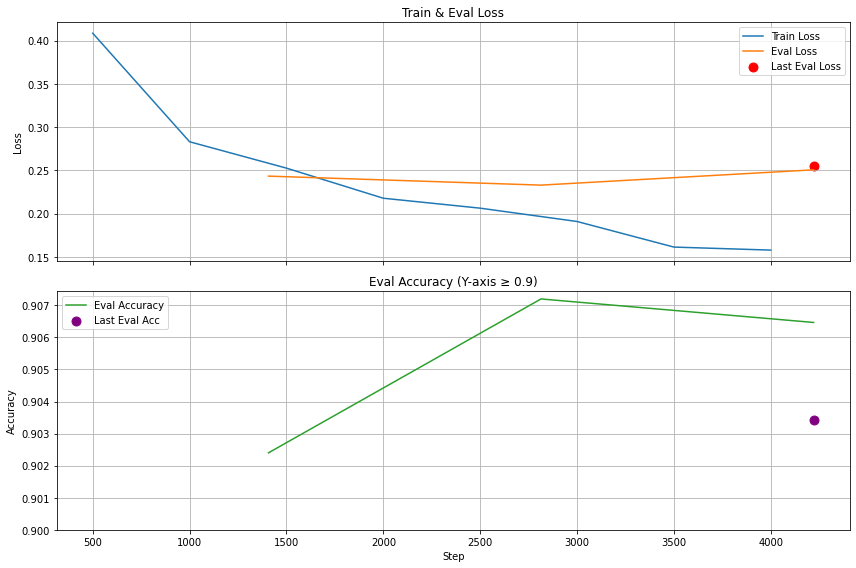

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# log_history에서 필요한 부분 정리
df = pd.DataFrame(trainer.state.log_history)
train_loss = df[df["loss"].notnull()]
eval_loss = df[df["eval_loss"].notnull()]
eval_acc = df[df["eval_accuracy"].notnull()]

# 마지막 평가 포인트 제외
eval_loss_main = eval_loss.iloc[:-1]
eval_loss_last = eval_loss.iloc[-1]

eval_acc_main = eval_acc.iloc[:-1]
eval_acc_last = eval_acc.iloc[-1]

# 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# (1) Train & Eval Loss Plot
ax1.plot(train_loss["step"], train_loss["loss"], label="Train Loss", color="tab:blue")
ax1.plot(eval_loss_main["step"], eval_loss_main["eval_loss"], label="Eval Loss", color="tab:orange")
ax1.scatter(eval_loss_last["step"], eval_loss_last["eval_loss"], color="red", s=80, marker="o", label="Last Eval Loss")
ax1.set_ylabel("Loss")
ax1.set_title("Train & Eval Loss")
ax1.legend()
ax1.grid(True)

# (2) Eval Accuracy Plot
ax2.plot(eval_acc_main["step"], eval_acc_main["eval_accuracy"], label="Eval Accuracy", color="tab:green")
ax2.scatter(eval_acc_last["step"], eval_acc_last["eval_accuracy"], color="purple", s=80, marker="o", label="Last Eval Acc")
ax2.set_xlabel("Step")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(bottom=0.9)  # 여기서 하한을 0.9로 고정
ax2.set_title("Eval Accuracy (Y-axis ≥ 0.9)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


### 회고

팀원들과 bucketing 적용 결과를 공유해보니

일부 팀원은 속도 하락+성능 하락을 겪었고,

일부 팀원은 속도 상승+성능 상승을 겪었습니다.

저의 경우 속도 상승과 성능 상승을 겪었는데,

이미 다이나믹 패딩을 적용한 상태에서 학습을 진행했기 때문에

패딩 길이가 기존과 변하지 않고 길이가 비슷한 데이터들을 한 번에 처리해서

성능이 향상된 것으로 보입니다.


(추가) padding=True로 tokenizer 단계에서 padding을 진행하면 다이나믹 패딩이 아니라 batched tokenizer padding이 적용되었음을 퀘스트를 통해 확인하였습니다.

batched tokenizer padding은 토크나이징 단계에서 토크나이저에 들어가는 배치만큼 padding하는것이고, padding=False로 적용하는 다이나믹 패딩은 훈련 중 배치만큼 padding하여 
새로운 배치마다 적용되는 다이나믹패딩이 더 유연하고 효율적인 방법이라는 점을 공부부할 수 있었습니다.